# Parseval Regularization vs None Regularization on Mnist Dataset

In [1]:
%matplotlib inline 
import matplotlib.pyplot as plt
import seaborn as sb
sb.set()

import pandas as pd
import numpy as np
import time
import tensorflow as tf
import tensorflow.keras.utils as ku
import tensorflow.keras.models as km
import tensorflow.keras.layers as kl
import tensorflow.keras.optimizers as ko
import tensorflow.keras.preprocessing.image as k
import numpy.linalg as npl
import foolbox as fb


from sklearn.metrics import confusion_matrix
tf.test.is_gpu_available()

Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.


False

In [2]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 15337493771042543825
, name: "/device:XLA_CPU:0"
device_type: "XLA_CPU"
memory_limit: 17179869184
locality {
}
incarnation: 7596786030380888150
physical_device_desc: "device: XLA_CPU device"
, name: "/device:XLA_GPU:0"
device_type: "XLA_GPU"
memory_limit: 17179869184
locality {
}
incarnation: 14296754183562421993
physical_device_desc: "device: XLA_GPU device"
]


In [22]:
from tensorflow.python.keras.constraints import Constraint
from tensorflow.python.ops import math_ops, array_ops

class TightFrame(Constraint):
    """
    Parseval (tight) frame contstraint, as introduced in https://arxiv.org/abs/1704.08847
    Constraints the weight matrix to be a tight frame, so that the Lipschitz
    constant of the layer is <= 1. This increases the robustness of the network
    to adversarial noise.
    Warning: This constraint simply performs the update step on the weight matrix
    (or the unfolded weight matrix for convolutional layers). Thus, it does not
    handle the necessary scalings for convolutional layers.
    Args:
        scale (float):    Retraction parameter (length of retraction step).
        num_passes (int): Number of retraction steps.
    Returns:
        Weight matrix after applying regularizer.
    """


    def __init__(self, scale, num_passes=1):
        self.scale = scale

        if num_passes < 1:
            raise ValueError("Number of passes cannot be non-positive! (got {})".format(num_passes))
        self.num_passes = num_passes


    def __call__(self, w):
        transpose_channels = (len(w.shape) == 4)

        # Move channels_num to the front in order to make the dimensions correct for matmul
        if transpose_channels:
            w_reordered = array_ops.reshape(w, (-1, w.shape[3]))

        else:
            w_reordered = w

        last = w_reordered
        for i in range(self.num_passes):
            temp1 = math_ops.matmul(last, last, transpose_a=True)
            temp2 = (1 + self.scale) * w_reordered - self.scale * math_ops.matmul(w_reordered, temp1)

            last = temp2

        # Move channels_num to the back again
        if transpose_channels:
            return array_ops.reshape(last, w.shape)
        else:
            return last


    def get_config(self):
        return {'scale': self.scale, 'num_passes': self.num_passes}


# Alias
tight_frame = TightFrame

# Import the Dataset MNIST

In [4]:
from tensorflow.keras.datasets import mnist

(X_train, Y_train), (X_test, Y_test) = mnist.load_data()
N_train, N_x_pixels, N_y_pixels = X_train.shape
N_test = X_test.shape[0]
N_classes = len(set(Y_train))

print("Train data : %d images  (%d/%d pixels)" %(N_train, N_x_pixels, N_y_pixels))
print("Test data : %d images  (%d/%d pixels)" %(N_test, N_x_pixels, N_y_pixels))

Train data : 60000 images  (28/28 pixels)
Test data : 10000 images  (28/28 pixels)


# Image example

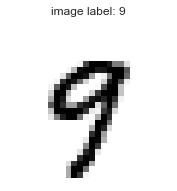

In [5]:
sample_index = 45
fig =plt.figure(figsize=(3, 3))
ax = fig.add_subplot(1,1,1)
ax.imshow(X_train[sample_index], cmap=plt.cm.gray_r, interpolation='nearest')
ax.set_title("image label: %d" % Y_train[sample_index])
ax.grid(False)
ax.axis('off')
plt.show()

### Data format
Some modifications are required on the data to use them with our model.

The first layer is a Dense Layer, which handles 1D vectors as an input. We must first reshape the 2D 28x28 images as a 1D $28*28=784$ vector.

In [6]:
X_train_flatten = X_train.reshape((N_train, N_x_pixels*N_y_pixels))/255
X_test_flatten = X_test.reshape((N_test, N_x_pixels*N_y_pixels))/255
N_dim_flatten = X_train_flatten.shape[1]
print("Dimensions of flatten train images : %d X %d" %(X_train_flatten.shape))
print("Dimensions of flatten test images : %d X %d" %(X_test_flatten.shape))

X_train_conv = np.expand_dims(X_train,axis=-1)
X_test_conv = np.expand_dims(X_test,axis=-1)
X_train_conv.shape

print("\nDimensions of conv train images : %d X %d X %d X %d" %(X_train_conv.shape))
print("Dimensions of conv test images : %d X %d X %d X %d" %(X_test_conv.shape))

Dimensions of flatten train images : 60000 X 784
Dimensions of flatten test images : 10000 X 784

Dimensions of conv train images : 60000 X 28 X 28 X 1
Dimensions of conv test images : 10000 X 28 X 28 X 1


### Architecture

In [7]:
# Définition du réseau
model = km.Sequential()
model.add(kl.Conv2D(filters = 6, kernel_size = 5, strides = 1, activation = 'tanh',
input_shape = (28,28,1)))
model.add(kl.MaxPooling2D(pool_size = 2, strides = 2))
model.add(kl.Conv2D(filters = 16, kernel_size = 5,strides = 1, activation = 'tanh'))
model.add(kl.MaxPooling2D(pool_size = 2, strides = 2))
model.add(kl.Flatten())
model.add(kl.Dense(units = 120, activation = 'tanh'))
model.add(kl.Dense(units = 84, activation = 'tanh'))
model.add(kl.Dense(units = 10, activation = 'softmax'))

#Résumé
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 24, 24, 6)         156       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 12, 12, 6)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 8, 8, 16)          2416      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 4, 4, 16)          0         
_________________________________________________________________
flatten (Flatten)            (None, 256)               0         
_________________________________________________________________
dense (Dense)                (None, 120)               30840     
_________________________________________________________________
dense_1 (Dense)              (None, 84)                1

### Training

In [8]:
model.compile(loss='sparse_categorical_crossentropy',
              optimizer=ko.RMSprop(),
              metrics=['accuracy'])

batch_size = 128
epochs=30
ts = time.time()
history = model.fit(X_train_conv, Y_train,
                    batch_size=batch_size,
                    epochs=epochs,
                    verbose=1,
                    validation_data = (X_test_conv, Y_test))
te = time.time()
t_train_mpl = te-ts

Epoch 1/30
469/469 [==============================] - 10s 21ms/step - loss: 0.2536 - accuracy: 0.9259 - val_loss: 0.0977 - val_accuracy: 0.9701
Epoch 2/30
469/469 [==============================] - 9s 19ms/step - loss: 0.0946 - accuracy: 0.9710 - val_loss: 0.0711 - val_accuracy: 0.9776
Epoch 3/30
469/469 [==============================] - 9s 20ms/step - loss: 0.0693 - accuracy: 0.9783 - val_loss: 0.0625 - val_accuracy: 0.9800
Epoch 4/30
469/469 [==============================] - 9s 20ms/step - loss: 0.0550 - accuracy: 0.9824 - val_loss: 0.0628 - val_accuracy: 0.9815
Epoch 5/30
469/469 [==============================] - 8s 18ms/step - loss: 0.0454 - accuracy: 0.9859 - val_loss: 0.0545 - val_accuracy: 0.9807
Epoch 6/30
469/469 [==============================] - 8s 18ms/step - loss: 0.0408 - accuracy: 0.9873 - val_loss: 0.0575 - val_accuracy: 0.9823
Epoch 7/30
469/469 [==============================] - 9s 18ms/step - loss: 0.0357 - accuracy: 0.9882 - val_loss: 0.0482 - val_accuracy: 0.985

### Results

Test loss: 0.07558668404817581
Test accuracy: 0.9840999841690063
Time Running: 269.11 seconds


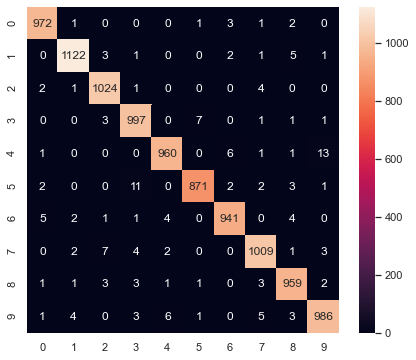

In [9]:
score = model.evaluate(X_test_conv, Y_test, verbose=0)
predict = model.predict(X_test_conv)
print('Test loss:', score[0])
print('Test accuracy:', score[1])
print("Time Running: %.2f seconds" %t_train_mpl )

fig=plt.figure(figsize=(7,6))
ax = fig.add_subplot(1,1,1)
ax = sb.heatmap(pd.DataFrame(confusion_matrix(Y_test, predict.argmax(1))), annot=True, fmt="d")

## Now with Parseval Architecture

In [26]:
Beta = 0.0003

def Parseval(W):
    W_t = tf.transpose(W)
    shape = W.shape[1]
    d = tf.matmul(W_t, W) - tf.eye(shape) 
    return Beta * tf.reduce_sum(d**2)

def ParsevalConv(W):
    W = tf.reshape(W, (-1, W.shape[-1]))
    W_t = tf.transpose(W)
    shape = W.shape[1]
    d = tf.matmul(W_t, W) - tf.eye(shape) 
    return Beta * tf.reduce_sum(d**2)

# Définition du réseau
model_Parseval = km.Sequential()
model_Parseval.add(kl.Conv2D(filters = 6, kernel_size = 5, strides = 1, activation = 'tanh',kernel_constraint=tight_frame(0.001, 1),
input_shape = (28,28,1)))
model_Parseval.add(kl.MaxPooling2D(pool_size = 2, strides = 2))
model_Parseval.add(kl.Conv2D(filters = 16, kernel_size = 5,strides = 1, activation = 'tanh',kernel_constraint=tight_frame(0.001, 1)))
model_Parseval.add(kl.MaxPooling2D(pool_size = 2, strides = 2))
model_Parseval.add(kl.Flatten())
model_Parseval.add(kl.Dense(units = 120, activation = 'tanh',kernel_constraint=tight_frame(0.001, 1)))
model_Parseval.add(kl.Dense(units = 84, activation = 'tanh',kernel_constraint=tight_frame(0.001, 1)))
model_Parseval.add(kl.Dense(units = 10, activation = 'softmax',kernel_constraint=tight_frame(0.001, 1)))#,kernel_regularizer = Parseval))

#Résumé
model_Parseval.summary()

Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_18 (Conv2D)           (None, 24, 24, 6)         156       
_________________________________________________________________
max_pooling2d_18 (MaxPooling (None, 12, 12, 6)         0         
_________________________________________________________________
conv2d_19 (Conv2D)           (None, 8, 8, 16)          2416      
_________________________________________________________________
max_pooling2d_19 (MaxPooling (None, 4, 4, 16)          0         
_________________________________________________________________
flatten_9 (Flatten)          (None, 256)               0         
_________________________________________________________________
dense_27 (Dense)             (None, 120)               30840     
_________________________________________________________________
dense_28 (Dense)             (None, 84)               

### Training

In [28]:
model_Parseval.compile(loss='sparse_categorical_crossentropy',
              optimizer=ko.RMSprop(),
              metrics=['accuracy'])

batch_size = 128
epochs = 30
ts = time.time()
history2 = model_Parseval.fit(X_train_conv, Y_train,
                    batch_size = batch_size,
                    epochs = epochs,
                    verbose = 2,
                    validation_data = (X_test_conv, Y_test))
te = time.time()
t_train_mpl2 = te-ts

Epoch 1/30
469/469 - 8s - loss: 0.0585 - accuracy: 0.9843 - val_loss: 0.0664 - val_accuracy: 0.9814
Epoch 2/30
469/469 - 8s - loss: 0.0552 - accuracy: 0.9852 - val_loss: 0.0589 - val_accuracy: 0.9834
Epoch 3/30
469/469 - 8s - loss: 0.0529 - accuracy: 0.9867 - val_loss: 0.0639 - val_accuracy: 0.9827
Epoch 4/30
469/469 - 8s - loss: 0.0520 - accuracy: 0.9866 - val_loss: 0.0604 - val_accuracy: 0.9825
Epoch 5/30
469/469 - 8s - loss: 0.0507 - accuracy: 0.9873 - val_loss: 0.0568 - val_accuracy: 0.9842
Epoch 6/30
469/469 - 8s - loss: 0.0495 - accuracy: 0.9876 - val_loss: 0.0626 - val_accuracy: 0.9814
Epoch 7/30
469/469 - 8s - loss: 0.0496 - accuracy: 0.9875 - val_loss: 0.0544 - val_accuracy: 0.9838
Epoch 8/30
469/469 - 8s - loss: 0.0478 - accuracy: 0.9878 - val_loss: 0.0554 - val_accuracy: 0.9850
Epoch 9/30
469/469 - 8s - loss: 0.0478 - accuracy: 0.9873 - val_loss: 0.0607 - val_accuracy: 0.9824
Epoch 10/30
469/469 - 8s - loss: 0.0469 - accuracy: 0.9880 - val_loss: 0.0528 - val_accuracy: 0.9854

### Results

Test loss: 0.04767768457531929
Test accuracy: 0.9866999983787537
Time Running: 249.24 seconds


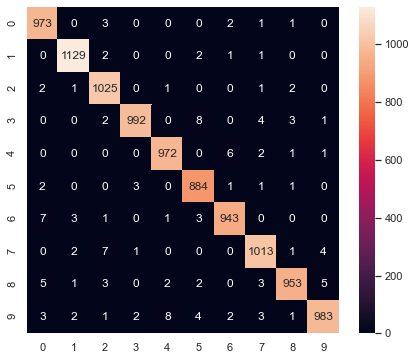

In [29]:
score2 = model_Parseval.evaluate(X_test_conv, Y_test, verbose=0)
predict2 = model_Parseval.predict(X_test_conv)
print('Test loss:', score2[0])
print('Test accuracy:', score2[1])
print("Time Running: %.2f seconds" %t_train_mpl2 )

fig=plt.figure(figsize=(7,6))
ax = fig.add_subplot(1,1,1)
ax = sb.heatmap(pd.DataFrame(confusion_matrix(Y_test, predict2.argmax(1))), annot=True, fmt="d")

In [33]:
Noise = np.random.normal(0,3,(10000, 28, 28, 1))
X_test_conv_noisy = X_test_conv + 1 * Noise 

### Add noise in None vs Add noise in Parseval

Model Vanilla
Test loss: 0.5317695736885071
Test accuracy: 0.8852999806404114


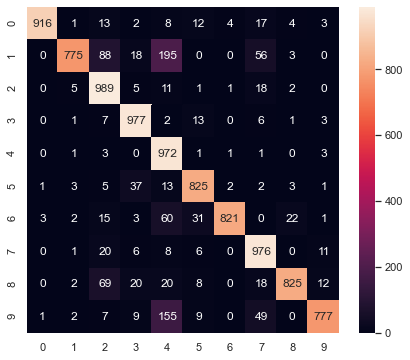

In [34]:
score = model.evaluate(X_test_conv_noisy, Y_test, verbose=0)
predict = model.predict(X_test_conv_noisy)
print('Model Vanilla')
print('Test loss:', score[0])
print('Test accuracy:', score[1])
#print("Time Running: %.2f seconds" %t_train_mpl )

fig=plt.figure(figsize=(7,6))
ax = fig.add_subplot(1,1,1)
ax = sb.heatmap(pd.DataFrame(confusion_matrix(Y_test, predict.argmax(1))), annot=True, fmt="d")

Model Parseval
Test loss: 0.3028912842273712
Test accuracy: 0.8977000117301941


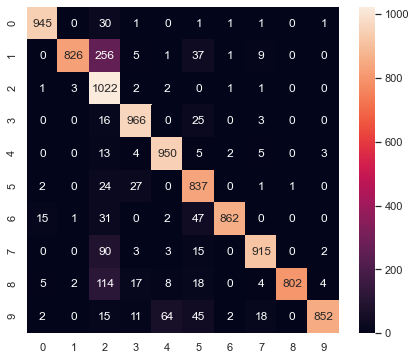

In [35]:
score2 = model_Parseval.evaluate(X_test_conv_noisy, Y_test, verbose = 0)
predict2 = model_Parseval.predict(X_test_conv_noisy)
print('Model Parseval')
print('Test loss:', score2[0])
print('Test accuracy:', score2[1])
#print("Time Running: %.2f seconds" %t_train_mpl2 )

fig=plt.figure(figsize=(7,6))
ax = fig.add_subplot(1,1,1)
ax = sb.heatmap(pd.DataFrame(confusion_matrix(Y_test, predict2.argmax(1))), annot=True, fmt="d")

In [36]:
def Get_W_and_B(model):
    RES_W = []
    RES_B = []
    for i in range(len(model.layers)):
        Weights_and_bias = model.layers[i].weights
        if len(Weights_and_bias)>0:
            res_W = tf.make_ndarray(tf.make_tensor_proto(tf.convert_to_tensor(Weights_and_bias[0]))) # Weights
            RES_W += [res_W]
            res_b = tf.make_ndarray(tf.make_tensor_proto(tf.convert_to_tensor(Weights_and_bias[1]))) # Bias
            RES_B += [res_b]
    return RES_W, RES_B

In [37]:
def Check_Parseval(RES_W, indice):
    res = (RES_W[indice].T)@RES_W[indice]
    plt.imshow(res)
    plt.colorbar()
    print(np.diag(res))
    plt.title("W.t x W for the layer k = " + str(indice+1),fontsize=20)


[1.2180216 1.1306434 1.1905583 1.1931686 1.2417884 1.1732595 1.1839567
 1.1772829 1.1430591 1.1656855 1.1489134 1.165456  1.1336387 1.151868
 1.1782894 1.2120949 1.1299329 1.1187053 1.1992451 1.1355003 1.1563613
 1.1225364 1.1543615 1.185924  1.1642381 1.149836  1.1075296 1.19865
 1.1720222 1.220348  1.2036084 1.1679643 1.1801503 1.2158684 1.2218926
 1.1857287 1.1922671 1.1425571 1.1385909 1.1402595 1.2258646 1.1357038
 1.1953018 1.1411793 1.161908  1.1862482 1.1664956 1.2022647 1.189298
 1.165993  1.1138402 1.1260334 1.1647161 1.1353587 1.1769367 1.1711494
 1.1934434 1.181366  1.2125621 1.2232721 1.1506492 1.2148147 1.1680578
 1.1605334 1.146526  1.2271605 1.2088219 1.2349628 1.1485023 1.1902035
 1.1228361 1.198591  1.1308008 1.2139539 1.2142892 1.1920208 1.1466482
 1.160665  1.1508925 1.1878685 1.1818596 1.1708862 1.2149564 1.130823
 1.1392126 1.1801293 1.120336  1.1689693 1.1673408 1.1430781 1.1743528
 1.1562796 1.1529443 1.1246461 1.1830885 1.1329839 1.166799  1.1558925
 1.2161926 

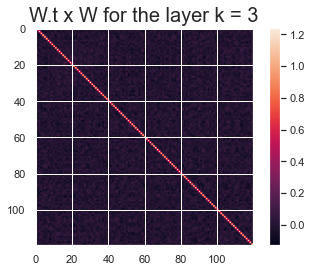

In [38]:
RES_Wbad, RES_Bbad = Get_W_and_B(model)

RES_W, RES_B = Get_W_and_B(model_Parseval)
Check_Parseval(RES_W,2)

### On a une matrice qui est bien diagonale comme la matrice identité.

In [41]:
ind = 1
_, Db1, _ = npl.svd(RES_Wbad[ind],full_matrices=False)
_, D1, _ = npl.svd(RES_W[ind],full_matrices=False)
np.shape(D1)

(5, 5, 6)

In [43]:
ind = 2
_, Db2, _ = npl.svd(RES_Wbad[ind],full_matrices=False)
_, D2, _ = npl.svd(RES_W[ind],full_matrices=False)

In [44]:
ind = 3
_, Db3, _ = npl.svd(RES_Wbad[ind],full_matrices=False)
_, D3, _ = npl.svd(RES_W[ind],full_matrices=False)

In [45]:
ind = 4
_, Db4, _ = npl.svd(RES_Wbad[ind],full_matrices=False)
_, D4, _ = npl.svd(RES_W[ind],full_matrices=False)

In [46]:
print(len(D4))
print(len(D3))
print(len(D2))

10
84
120


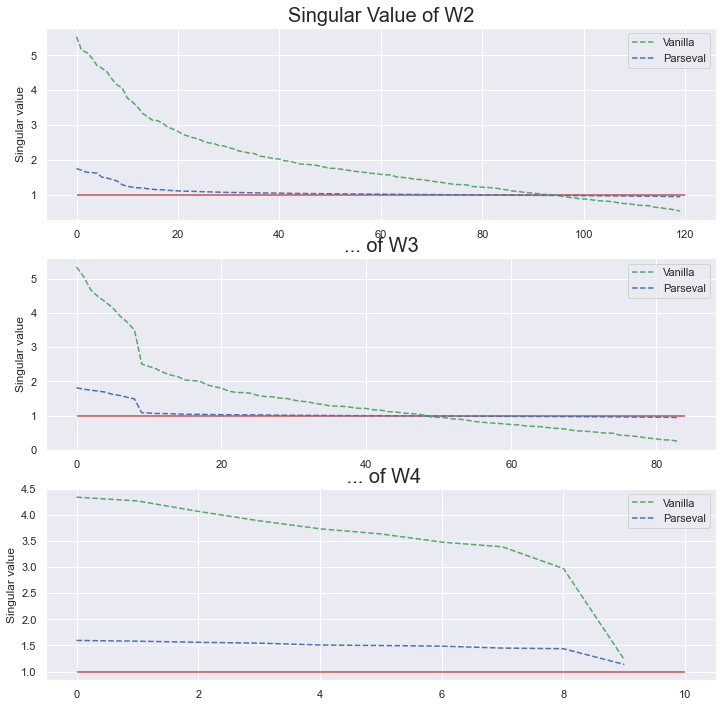

In [47]:
from pylab import rcParams
rcParams['figure.figsize'] = 12, 12

fig, axs = plt.subplots(3, 1)


axs[0].plot(Db2,'g--',label='Vanilla')
axs[0].plot(D2,'b--',label='Parseval')
axs[0].hlines(1,0,len(D2),color='r')
axs[0].set_title("Singular Value of W2",fontsize=20)
axs[0].legend()


axs[1].plot(Db3,'g--',label='Vanilla')
axs[1].plot(D3,'b--',label='Parseval')
axs[1].hlines(1,0,len(D3),color='r')
axs[1].set_title("... of W3",fontsize=20)
axs[1].legend()

axs[2].plot(Db4,'g--',label='Vanilla')
axs[2].plot(D4,'b--',label='Parseval')
axs[2].hlines(1,0,len(D4),color='r')
axs[2].set_title(" ... of W4",fontsize=20)
axs[2].legend()

for ax in axs.flat:
    ax.set(ylabel='Singular value')

# Hide x labels and tick labels for top plots and y ticks for right plots.


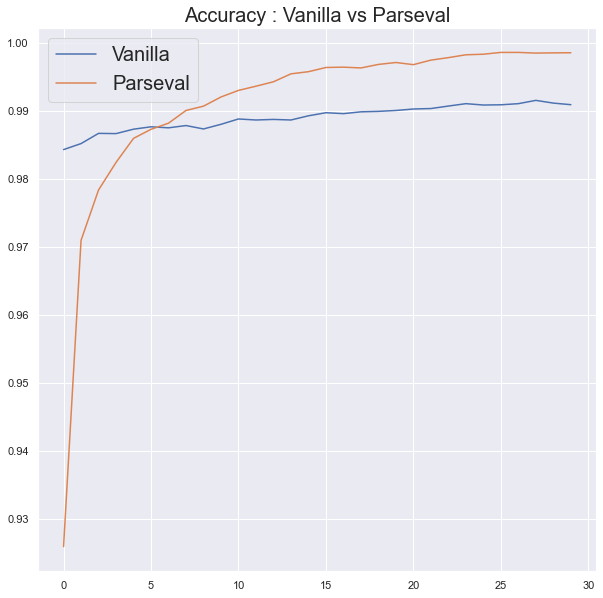

In [48]:
rcParams['figure.figsize'] = 10, 10

plt.title("Accuracy : Vanilla vs Parseval",fontsize=20)
plt.plot(history2.history['accuracy'],label='Vanilla')
plt.plot(history.history['accuracy'],label='Parseval')
plt.legend(fontsize=20)
plt.show()

In [26]:
(x_trainC10, y_trainC10), (x_testC10, y_testC10) = tf.keras.datasets.cifar10.load_data()

In [27]:
N_train, N_x_pixels, N_y_pixels, N_color = x_trainC10.shape
N_test = x_testC10.shape[0]
N_classes = len(set(y_trainC10[:,0]))

print("Train data : %d images  (%d/%d pixels) with %d channels" %(N_train, N_x_pixels, N_y_pixels,N_color))
print("Test data : %d images  (%d/%d pixels) with %d channels" %(N_test, N_x_pixels, N_y_pixels,N_color))

Train data : 50000 images  (32/32 pixels) with 3 channels
Test data : 10000 images  (32/32 pixels) with 3 channels


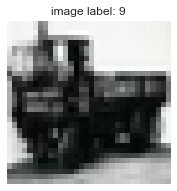

In [28]:
sample_index = 205
fig = plt.figure(figsize=(3, 3))
ax = fig.add_subplot(1,1,1)
ax.imshow(x_trainC10[sample_index], cmap=plt.cm.gray_r, interpolation='nearest')
ax.set_title("image label: %d" % y_trainC10[sample_index])
ax.grid(False)
ax.axis('off')
plt.show()

In [29]:
(x_trainC100, y_trainC100), (x_testC100, y_testC100) = tf.keras.datasets.cifar100.load_data()

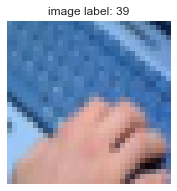

In [30]:
sample_index = 10
fig = plt.figure(figsize=(3, 3))
ax = fig.add_subplot(1,1,1)
ax.imshow(x_trainC100[sample_index], cmap=plt.cm.gray_r, interpolation='nearest')
ax.set_title("image label: %d" % y_trainC100[sample_index])
ax.grid(False)
ax.axis('off')
plt.show()

In [6]:
#model = tf.keras.applications.ResNet50V2(weights="imagenet")

102875136/102869336 [==============================] - 42s 0us/step


In [104]:
preprocessing = dict()
bounds = (0, 9)
fmodel_Parseval = fb.TensorFlowModel(model_Parseval, bounds=bounds, preprocessing=preprocessing)

fmodel = fb.TensorFlowModel(model, bounds=bounds, preprocessing=preprocessing)

In [105]:
#fmodel = fmodel.transform_bounds((0, 1))
#fmodel_Parseval = fmodel_Parseval.transform_bounds((0, 1))

In [145]:
images, labels = fb.utils.samples(fmodel, dataset='mnist', batchsize=16)
images2, labels2 = fb.utils.samples(fmodel_Parseval, dataset='mnist', batchsize=16)


In [146]:
fb.utils.accuracy(fmodel, images, labels)
fb.utils.accuracy(fmodel_Parseval, images2, labels2)

1.0

In [147]:
attack = fb.attacks.LinfDeepFoolAttack()

In [148]:

import eagerpy as ep

In [149]:
images = ep.astensor(images)
labels = ep.astensor(labels)

images2 = ep.astensor(images2)
labels2 = ep.astensor(labels2)

In [150]:
epsilons = np.linspace(0.0, 0.5, num=50)

In [151]:
raw, clipped, is_adv = attack(fmodel, images, labels, epsilons=epsilons)
raw2, clipped2, is_adv2 = attack(fmodel_Parseval, images2, labels2, epsilons=epsilons)


In [137]:
is_adv.shape

(50, 16)

In [138]:
is_adv.float32().mean(axis=-1)

TensorFlowTensor(<tf.Tensor: shape=(50,), dtype=float32, numpy=
                 array([0.    , 0.    , 0.    , 0.    , 0.    , 0.    , 0.    , 0.    ,
                        0.0625, 0.0625, 0.0625, 0.0625, 0.0625, 0.0625, 0.0625, 0.1875,
                        0.1875, 0.1875, 0.1875, 0.1875, 0.1875, 0.1875, 0.1875, 0.1875,
                        0.1875, 0.1875, 0.1875, 0.1875, 0.1875, 0.1875, 0.1875, 0.1875,
                        0.1875, 0.1875, 0.1875, 0.1875, 0.1875, 0.1875, 0.1875, 0.1875,
                        0.1875, 0.1875, 0.1875, 0.1875, 0.1875, 0.1875, 0.25  , 0.25  ,
                        0.25  , 0.25  ], dtype=float32)>)

In [152]:
robust_accuracy = 1 - is_adv.float32().mean(axis=-1)
robust_accuracy2 = 1 - is_adv2.float32().mean(axis=-1)

In [140]:
robust_accuracy

TensorFlowTensor(<tf.Tensor: shape=(50,), dtype=float32, numpy=
                 array([1.    , 1.    , 1.    , 1.    , 1.    , 1.    , 1.    , 1.    ,
                        0.9375, 0.9375, 0.9375, 0.9375, 0.9375, 0.9375, 0.9375, 0.8125,
                        0.8125, 0.8125, 0.8125, 0.8125, 0.8125, 0.8125, 0.8125, 0.8125,
                        0.8125, 0.8125, 0.8125, 0.8125, 0.8125, 0.8125, 0.8125, 0.8125,
                        0.8125, 0.8125, 0.8125, 0.8125, 0.8125, 0.8125, 0.8125, 0.8125,
                        0.8125, 0.8125, 0.8125, 0.8125, 0.8125, 0.8125, 0.75  , 0.75  ,
                        0.75  , 0.75  ], dtype=float32)>)

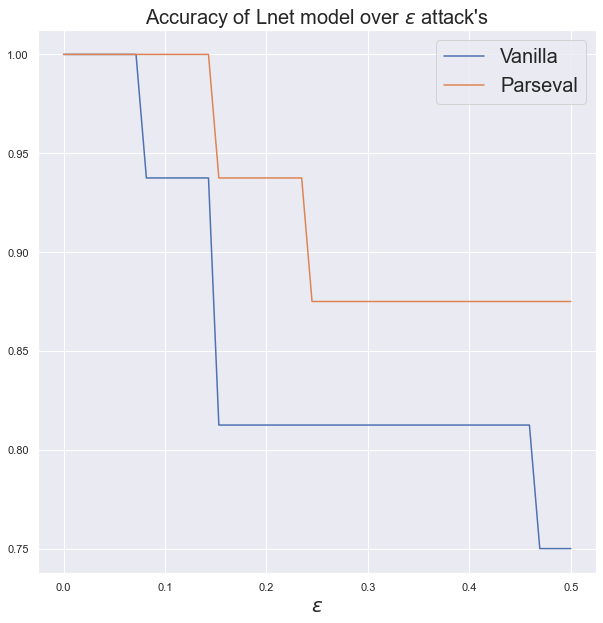

In [157]:
plt.title(f"Accuracy of Lnet model over $\epsilon$ attack's ",fontsize=20)
plt.xlabel(f"$\epsilon$",fontsize=20)
plt.plot(epsilons, robust_accuracy.numpy(),label="Vanilla")
plt.plot(epsilons, robust_accuracy2.numpy(),label="Parseval")
plt.legend(fontsize=20)
plt.show()